## Sentiment analysis for Customer satisfaction towards product 

#### Introduction

In [15]:
# import the necessary libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# read the data

data = pd.read_csv('..\data\judge-1377884607_tweet_product_company.csv', encoding='latin-1')

data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
data.shape

(9093, 3)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [11]:
data.rename({'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'product_brand', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, axis=1, inplace=True)

In [12]:
data.columns

Index(['tweet', 'product_brand', 'emotion'], dtype='object')

In [13]:
# number of product brands
data.product_brand.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product_brand, dtype: int64

In [14]:
# type of sentiment 
data.emotion.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

#### Distribution of sentiment in bar graph

Text(0.5, 1.0, 'Distribution of sentiment')

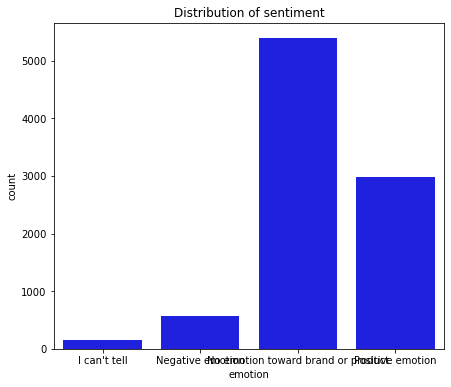

In [16]:
plt.figure(figsize=(7,6))
sns.countplot(x=data['emotion'].sort_values(), color='Blue')
plt.title('Distribution of sentiment')

Reviewing the emotions vs the product in use

Text(0.5, 1.0, 'Emotions Vs Product_brand')

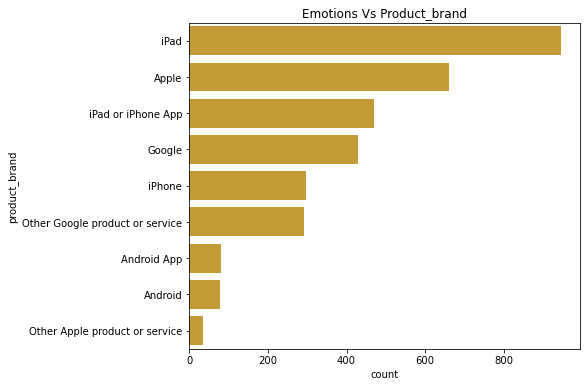

In [18]:
plt.figure(figsize=(7,6))
sns.countplot(y=data['product_brand'].sort_values(), order=data['product_brand'].value_counts().nlargest(10).index,
              color='goldenrod')
plt.title('Emotions Vs Product_brand')